# Theta-based Summary Statistics
## Site Frequency Spectrum
### Inferring Ancestral alleles
It is important to have the ancestral state for some of the analyses below. To this end, we used short reads sequenced by the [B10K](https://b10k.genomics.cn/species.html) consortium and stored by the China National GeneBank DataBase (CNGBdb) for large-bill tern ([*Phaetusa simplex*](https://db.cngb.org/search/organism/297813/) NCBI ID: 297813, CNGB Sample ID: CNS0103161, CNGB Experiment ID: CNX0082959) and black skimmer ([*Rhynchops niger*](https://db.cngb.org/search/organism/227184/) NCBI ID: 227184, CNGB Sample ID: CNS0103105, CNGB Experiment ID: CNX0082867 - CNX0082869) to polarise the site frequency spectrum for fairy terns. Whereas resequence data generated by [Galla et al 2019](https://doi.org/10.3390/genes10010009) for the avocet (*Recurvirostra avosetta*) and pied stilt (*Himantopus himantopus*) were used to polarise kakī. This ([brief discussion](https://www.biostars.org/p/298013/)) outlines the benefit of using this approach for ANGSD-base analyses. The reads for each of the outgroups were trimmed, aligned, and duplicates marked in the same manner as the fairy tern and kakī population short-reads.  

In [ ]:
# sra-tools blah blah
# Alignment
# Dup removal
# Downsampling

In [ ]:
angsd -P 16 -doFasta 2 -doCounts 1 -out ${ANGSD}tern_ancestral -i ${DIR}merged_tern_markdup_autosomes.bam
angsd -P 16 -doFasta 2 -doCounts 1 -out ${ANGSD}stilt_ancestral -i ${DIR}merged_stilt_markdup_autosomes.bam
angsd -P 16 -doFasta 2 -doCounts 1 -out ${ANGSD}pied_alleles -b pied.list
angsd -P 16 -doFasta 2 -doCounts 1 -out ${ANGSD}AFT_alleles -b AU.list

### SFS Estimation
We then estimated the SFS using ANGSD and realSFS.

In [ ]:
for TOOL in samtools neutral
    do
    printf "STARTED RUNNING ANGSD FOR $TOOL DATA SET AT "
    date
    if [[ "$TOOL" == "samtools" ]]
        then
        angsd -P 16 -b ${ANGSD}AU.list -ref $TREF -anc $TANC -out ${ANGSD}samtools/sfs/AU \
            -uniqueOnly 1 -remove_bads 1 -only_proper_pairs 1 -trim 0 -C 50 -baq 1 \
            -minMapQ 20 -minQ 20 -minInd 19 -setMinDepth 200 -setMaxDepth 420 -doCounts 1 \
            -GL 1 -doSaf 1
        angsd -P 16 -b ${ANGSD}TI.list -ref $TREF -anc $TANC -out ${ANGSD}samtools/sfs/TI \
            -uniqueOnly 1 -remove_bads 1 -only_proper_pairs 1 -trim 0 -C 50 -baq 1 \
            -minMapQ 20 -minQ20 -minInd 38 -setMinDepth 120 -setMaxDepth 280 -doCounts 1 \
            -GL 1 -doSaf 1
        angsd -P 16 -b ${ANGSD}KI.list -ref $KREF -anc $KANC -out ${ANGSD}samtools/sfs/KI \
            -uniqueOnly 1 -remove_bads 1 -only_proper_pairs 1 -trim 0 -C 50 -baq 1 \
            -minMapQ 20 -minQ20 -minInd 24 -setMinDepth 700 -setMaxDepth 1200 -doCounts 1 \
            -GL 1 -doSaf 1
    else
        angsd -P 16 -b ${ANGSD}AU.list -ref $TREF -anc $TANC -sites $TSITES -out ${ANGSD}neutral/sfs/AU \
            -uniqueOnly 1 -remove_bads 1 -only_proper_pairs 1 -trim 0 -C 50 -baq 1 \
            -minMapQ 20 -minQ 20 -minInd 19 -setMinDepth 200 -setMaxDepth 420 -doCounts 1 \
            -GL 1 -doSaf 1
        angsd -P 16 -b ${ANGSD}TI.list -ref $TREF -anc $TANC -sites $TSITES -out ${ANGSD}neutral/sfs/TI \
            -uniqueOnly 1 -remove_bads 1 -only_proper_pairs 1 -trim 0 -C 50 -baq 1 \
            -minMapQ 20 -minQ20 -minInd 38 -setMinDepth 120 -setMaxDepth 280 -doCounts 1 \
            -GL 1 -doSaf 1
        angsd -P 16 -b ${ANGSD}KI.list -ref $KREF -anc $KANC -sites $KSITES -out ${ANGSD}neutral/sfs/KI \
            -uniqueOnly 1 -remove_bads 1 -only_proper_pairs 1 -trim 0 -C 50 -baq 1 \
            -minMapQ 20 -minQ20 -minInd 24 -setMinDepth 700 -setMaxDepth 1200 -doCounts 1 \
            -GL 1 -doSaf 1
    fi
done

Then `realSFS` was run to estimate the site frequency spectrum and theta-based statistics.  

In [ ]:
realSFS -P 40 -anc ${TANC} -ref ${TREF} ${ANGSD}${TOOL}/sfs/AU.saf.idx > ${ANGSD}${TOOL}/sfs/AU.sfs
realSFS -P 40 -anc ${TANC} -ref ${TREF} ${ANGSD}${TOOL}/sfs/TI.saf.idx > ${ANGSD}${TOOL}/sfs/TI.sfs
realSFS -P 40 -anc ${KANC} -ref ${KREF} ${ANGSD}${TOOL}sfs/KI.saf.idx > ${ANGSD}${TOOL}sfs/KI.sfs
realSFS -P 40 -anc ${TANC} -ref ${TREF} ${ANGSD}${TOOL}/sfs/AU.saf.idx ${ANGSD}${TOOL}/sfs/TI.saf.idx > ${ANGSD}${TOOL}/sfs/GLOBAL.sfs

In [ ]:
i=0
printf 'Allele Count\tCount\n' > AU_neutral_modified.sfs
tr ' ' '\n' < ${ANGSD}neutral/sfs/AU.sfs | grep -v '^$' | while read -r line; do printf "${i}\t${line}\n"; i=$[i+1]; done >> AU_neutral_modified.sfs

In [5]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.legend_handler import HandlerTuple
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

path = '/nesi/nobackup/uc03718/'
os.chdir(path)
print(os.getcwd())

/nesi/nobackup/uc03718


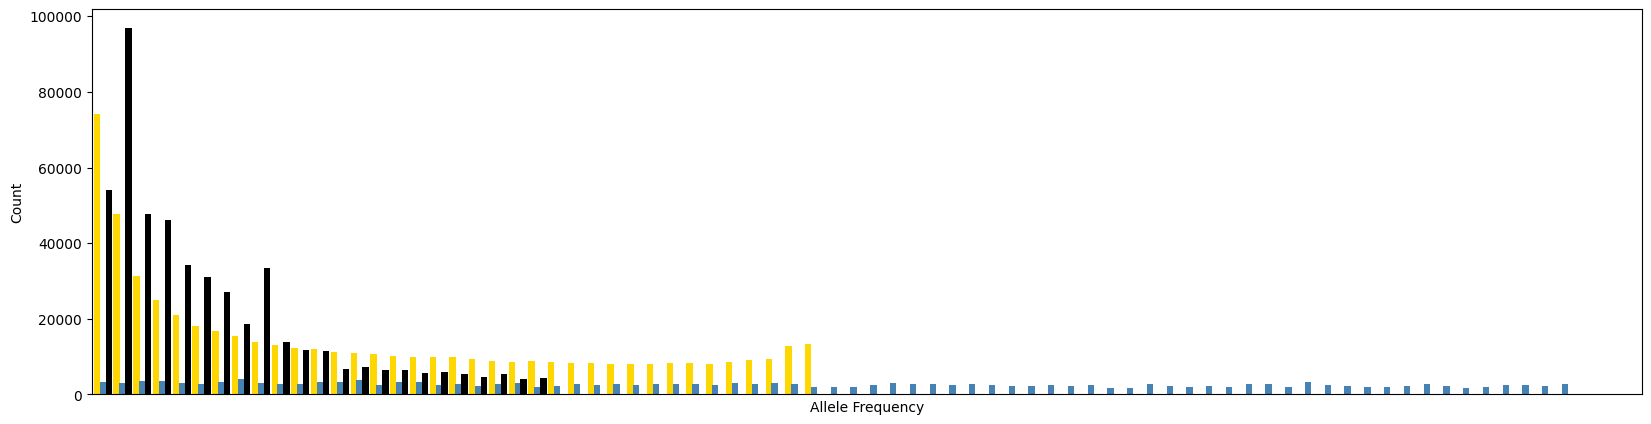

In [13]:
ausfs = pd.read_csv('angsd/neutral/sfs/AU_neutral_modified.sfs', sep='\t')
ausfs = ausfs.iloc[1:38]

tisfs = pd.read_csv('angsd/neutral/sfs/TI_neutral_modified.sfs', sep='\t')
tisfs = tisfs.iloc[1:76]

kisfs = pd.read_csv('angsd/neutral/sfs/KI_neutral_modified.sfs', sep='\t')
kisfs = kisfs.iloc[1:24]

bar_width = 0.32

x_ausfs = ausfs['Allele Count']
x_tisfs = tisfs['Allele Count'] + bar_width - 0.02
x_kisfs = kisfs['Allele Count'] + 2 * bar_width - 0.04

plt.figure(figsize=(20, 5))
plt.bar(x_ausfs, ausfs['Count'], width=bar_width, color='gold')
plt.bar(x_tisfs, tisfs['Count'], width=bar_width, color='steelblue')
plt.bar(x_kisfs, kisfs['Count'], width=bar_width, color='black')

plt.xlim(left=0.75)
plt.xticks([])
plt.xlabel("Allele Frequency")
plt.ylabel("Count")

plt.savefig('Git_Repos/2026_S_nereis_Cons_Gen/Figures/SFS_neutralSites.png', dpi=300, bbox_inches='tight')

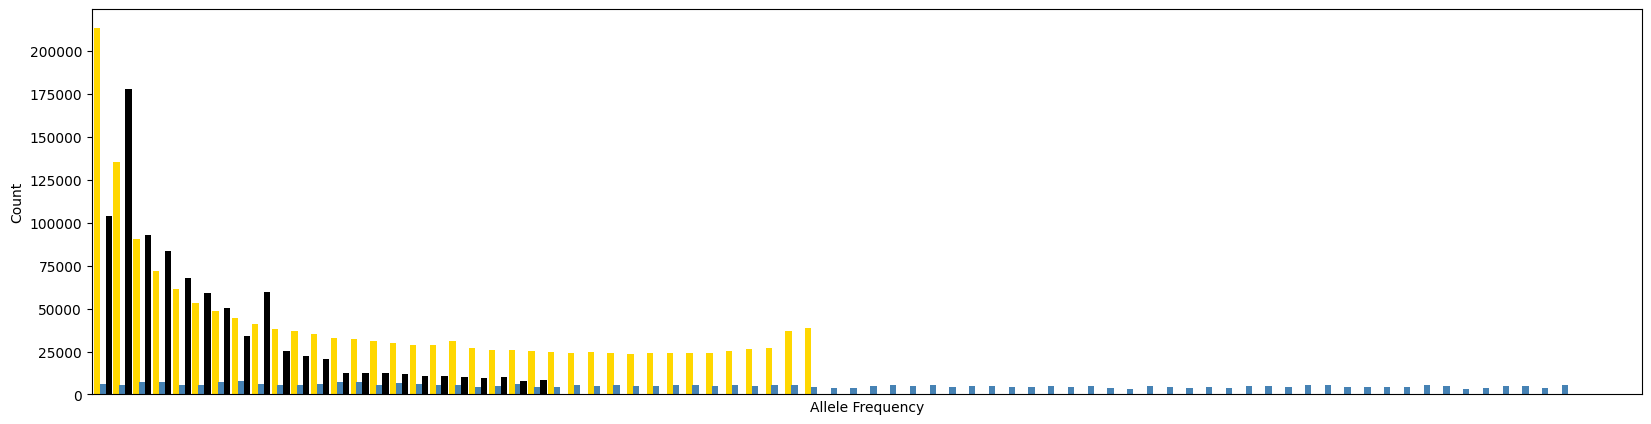

In [15]:
ausfs = pd.read_csv('angsd/samtools/sfs/AU_whole-genome_modified.sfs', sep='\t')
ausfs = ausfs.iloc[1:38]

tisfs = pd.read_csv('angsd/samtools/sfs/TI_whole-genome_modified.sfs', sep='\t')
tisfs = tisfs.iloc[1:76]

kisfs = pd.read_csv('angsd/samtools/sfs/KI_whole-genome_modified.sfs', sep='\t')
kisfs = kisfs.iloc[1:24]

bar_width = 0.32

x_ausfs = ausfs['Allele Count']
x_tisfs = tisfs['Allele Count'] + bar_width - 0.02
x_kisfs = kisfs['Allele Count'] + 2 * bar_width - 0.04

plt.figure(figsize=(20, 5))
plt.bar(x_ausfs, ausfs['Count'], width=bar_width, color='gold')
plt.bar(x_tisfs, tisfs['Count'], width=bar_width, color='steelblue')
plt.bar(x_kisfs, kisfs['Count'], width=bar_width, color='black')

plt.xlim(left=0.75)
plt.xticks([])
plt.xlabel("Allele Frequency")
plt.ylabel("Count")

plt.savefig('Git_Repos/2026_S_nereis_Cons_Gen/Figures/SFS_whole-genomeSites.png', dpi=300, bbox_inches='tight')

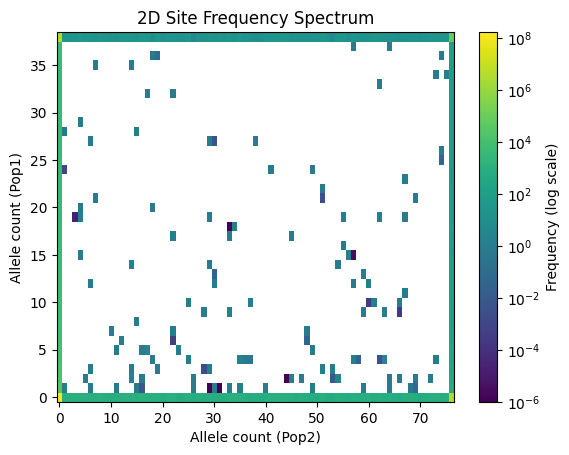

In [15]:
from matplotlib.colors import LogNorm 

# 2-dimesional heatmap
# Load the 2D SFS from realSFS
sfs_flat = np.loadtxt("angsd/neutral/sfs/GLOBAL2.sfs")

# Reshape into (n1+1, n2+1) — you must know your sample sizes
n1 = 19 * 2  # haploid count for pop1
n2 = 38 * 2  # haploid count for pop2
sfs2d = sfs_flat.reshape((n1+1, n2+1))

# Plot
plt.imshow(sfs2d, origin="lower", cmap="viridis", aspect="auto", norm=LogNorm())
plt.colorbar(label="Frequency (log scale)")
plt.xlabel("Allele count (Pop2)")
plt.ylabel("Allele count (Pop1)")
plt.title("2D Site Frequency Spectrum")
plt.show()

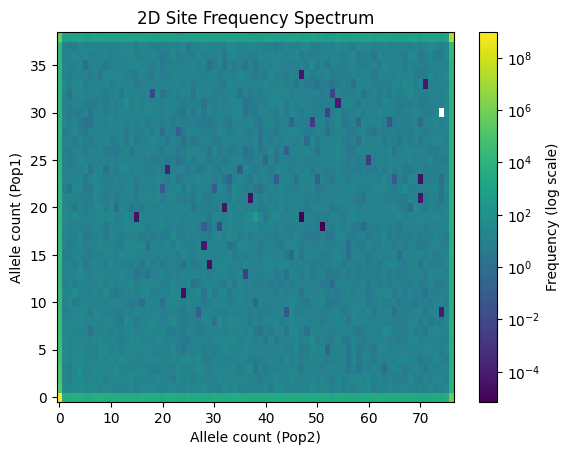

In [16]:
from matplotlib.colors import LogNorm 

# 2-dimesional heatmap
# Load the 2D SFS from realSFS
sfs_flat = np.loadtxt("angsd/samtools/sfs/GLOBAL2.sfs")

# Reshape into (n1+1, n2+1) — you must know your sample sizes
n1 = 19 * 2  # haploid count for pop1
n2 = 38 * 2  # haploid count for pop2
sfs2d = sfs_flat.reshape((n1+1, n2+1))

# Plot
plt.imshow(sfs2d, origin="lower", cmap="viridis", aspect="auto", norm=LogNorm())
plt.colorbar(label="Frequency (log scale)")
plt.xlabel("Allele count (Pop2)")
plt.ylabel("Allele count (Pop1)")
plt.title("2D Site Frequency Spectrum")
plt.show()

## Population Structure
### Estimating Population Differentiation (SNP-based Watterson's Theta)
Here we estimate Theta (F<sub>ST</sub>) between Australian fairy tern populations in Western Australia and tara iti. To do so, we leverage the site frequency spectrum (SFS) generated above.  

In [ ]:
realSFS fst index ${DIR}${TOOL}/sfs/AU.saf.idx ${DIR}${TOOL}/sfs/TI.saf.idx -sfs ${DIR}${TOOL}/sfs/GLOBAL.sfs -fstout ${DIR}${TOOL}/sfs/GLOBAL -whichFst 1
realSFS fst stats2 ${DIR}${TOOL}/sfs/GLOBAL.fst.idx \
    -tole 1e-6 -ref ${TREF} -anc ${TANC} \
    -win 10000 -step 1000 > ${DIR}${TOOL}/sfs/GLOBAL_stat2_10KBwindow_1KBstep.tsv

realSFS fst stats2 ${DIR}${TOOL}/sfs/GLOBAL.fst.idx \
    -tole 1e-6 -ref ${TREF} -anc ${TANC} \
    -win 50000 -step 10000 > ${DIR}${TOOL}/sfs/GLOBAL_stat2_50KBwindow_10KBstep.tsv

realSFS fst stats ${DIR}${TOOL}/sfs/GLOBAL.fst.idx \
    -tole 1e-6 -ref ${TREF} -anc $ANC \
    -win 50000 -step 10000 -whichFst 1 > ${ANGSD}${TOOL}sfs/GLOBAL_stat1_50KBwindow_10KBstep.tsv

The final command estimated a global weighted and unweighted F<sub>ST</sub> of `0.001981` and `0.838787` respectively for 259,924,909 putatively neutral sites and an unweighted F<sub>ST</sub> of `0.001987` and weighted F<sub>ST</sub> of `0.836593` for all 507,424,045 sites.  

In [6]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.legend_handler import HandlerTuple
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

path = '/nesi/nobackup/uc03718/'
os.chdir(path)
print(os.getcwd())

/nesi/nobackup/uc03718


/tmp/ipykernel_8340/2911366476.py:7: UserWarning: 
The palette list has fewer values (2) than needed (22) and will cycle, which may produce an uninterpretable plot.
  ax=sns.scatterplot(data=fst, x='x', y='FST', hue='chr', palette=palette, alpha=0.5, s=3, legend=False)


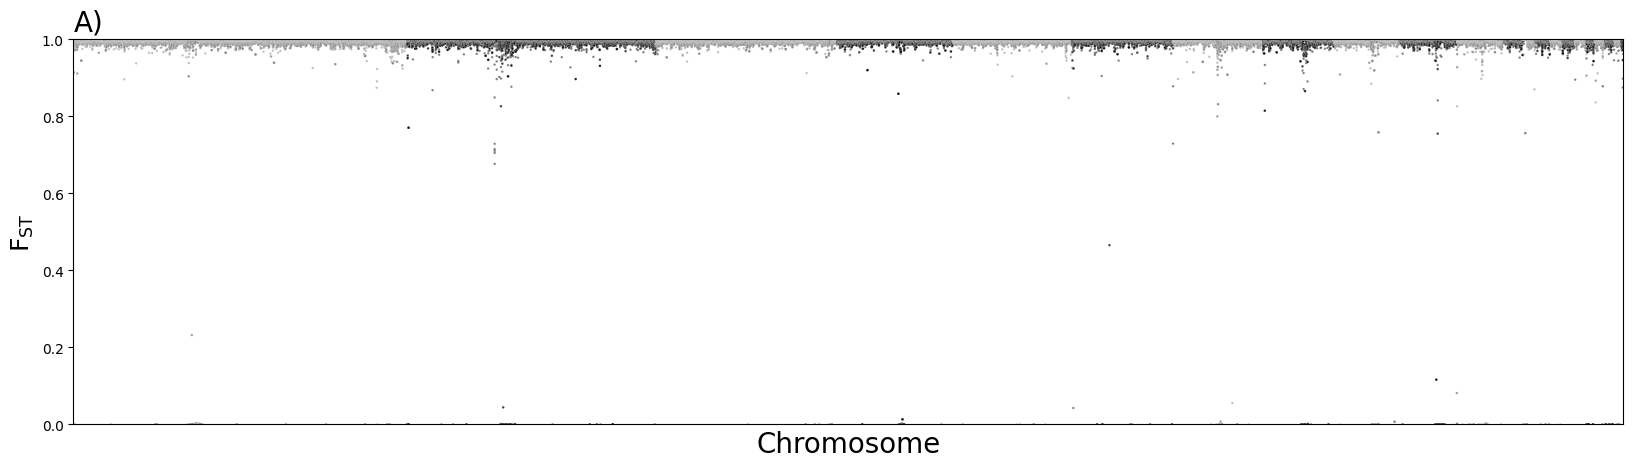

In [20]:
fst = pd.read_csv('angsd/neutral/sfs/GLOBAL_neutral_stat2_50KBwindow_10KBstep.tsv', sep='\t', usecols=['chr', 'midPos', 'Nsites', 'FST'])

fst['x'] = range(len(fst))

plt.figure(figsize=(20,5))
palette=['grey', 'black']
ax=sns.scatterplot(data=fst, x='x', y='FST', hue='chr', palette=palette, alpha=0.5, s=3, legend=False)

ax.set_title('A)', fontsize=20, loc='left')
ax.set_xlabel('Chromosome', fontsize=20)
ax.set_ylabel('$F_{ST}$', fontsize=18)
ax.set_xlim(0, 82449)
ax.set_ylim(0, 1)
ax.set_xticks([])

plt.savefig('Git_Repos/2026_S_nereis_Cons_Gen/Figures/GLOBAL_neutral_50KBwindow_10KBstep.png', dpi=300, bbox_inches='tight')

/tmp/ipykernel_8340/717876302.py:7: UserWarning: 
The palette list has fewer values (2) than needed (25) and will cycle, which may produce an uninterpretable plot.
  ax=sns.scatterplot(data=fst, x='x', y='FST', hue='chr', palette=palette, alpha=0.5, s=3, legend=False)


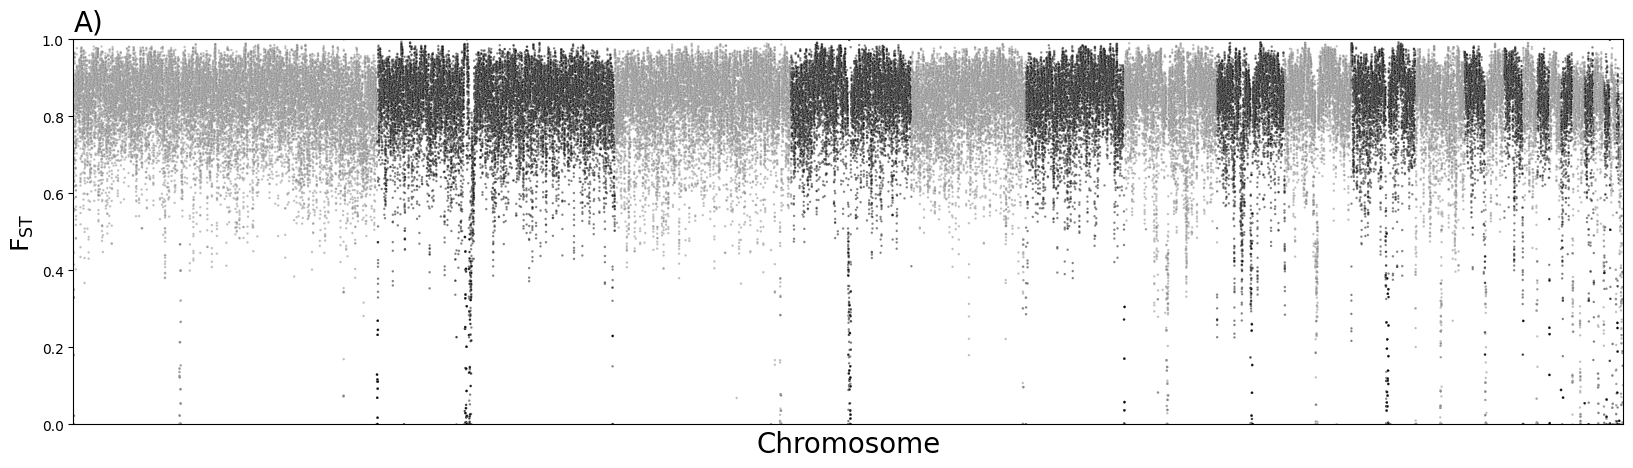

In [19]:
fst = pd.read_csv('angsd/samtools/sfs/GLOBAL_whole-genome_stat2_50KBwindow_10KBstep.tsv', sep='\t', usecols=['chr', 'midPos', 'Nsites', 'FST'])

fst['x'] = range(len(fst))

plt.figure(figsize=(20,5))
palette=['grey', 'black']
ax=sns.scatterplot(data=fst, x='x', y='FST', hue='chr', palette=palette, alpha=0.5, s=3, legend=False)

ax.set_title('A)', fontsize=20, loc='left')
ax.set_xlabel('Chromosome', fontsize=20)
ax.set_ylabel('$F_{ST}$', fontsize=18)
ax.set_xlim(0, 112302)
ax.set_ylim(0, 1)
ax.set_xticks([])

plt.savefig('Git_Repos/2026_S_nereis_Cons_Gen/Figures/GLOBAL_whole-genome_50KBwindow_10KBstep.png', dpi=300, bbox_inches='tight')

### MDS
To construct a MDS for fairy tern populations, we first ran ANGSD as below. Notably, here we add the `-doGeno 8` flag. 

In [ ]:
angsd -P 26 -b GLOBAL.list -ref $REF -anc $ANC -out ${ANGSD}structure_MDS/GLOBAL \
    -uniqueOnly 1 -remove_bads 1 -only_proper_pairs 1 -trim 0 -C 50 -baq 1 \
    -minMapQ 20 -minQ 20 -minInd 34 -setMinDepth 272 -setMaxDepth 630 -doCounts 1 \
    -GL 1 -doMajorMinor 1 -doMaf 1 -skipTriallelic 1 -SNP_pval 1e-6 -doGeno 8 -doPost 1

This command not only generates the required `*.mafs.gz`, but also the `*.geno.gz`, which contains posterior probabilities of all possible genotypes required for estimating genetic distance with [ngsDistv1.0.10](https://github.com/mfumagalli/ngsTools). In addition, a `pops.label` file denoting the population of origin (one entry on a new line for each samples) is necessary for estimating genetic distance.  

A total of 3,283,545 sites were used in the whole-genome and 1,686,352 were used in the neutral data set.  

Next we find the percent of variance explained by each axis.  

### Plotting SNP- and SV-based multiple dimensional scaling (MDS)
The high F<sub>ST</sub> inferred from SNP data corresponds to high differentiation observed in our MDS with over 97% and 84% of population variance represented along one dimension.  

In [49]:
import pandas as pd
import numpy as np
from numpy.linalg import eigh


def classical_mds(dist_matrix, n_components=2):
    """Classical MDS (equivalent to R's cmdscale)."""
    n = dist_matrix.shape[0]
    h = np.eye(n) - np.ones((n, n)) / n
    b = -0.5 * h.dot(dist_matrix**2).dot(h)

    eigvals, eigvecs = eigh(b)
    idx = np.argsort(eigvals)[::-1]
    eigvals, eigvecs = eigvals[idx], eigvecs[:, idx]

    w = np.where(eigvals > 0, np.sqrt(eigvals), 0)
    coords = eigvecs[:, :n_components] * w[:n_components]

    explained = 100 * eigvals[:n_components] / np.sum(eigvals[eigvals > 0])
    return coords, explained

def run_analysis_mds(
    in_file,
    n_comp=2,
    skip=0,
    no_header=False,
    out_file=None,
    sep="\t"
):
    """
    Run classical MDS on a distance matrix file.

    Parameters:
    - in_file: str, path to file
    - n_comp: int, number of dimensions to keep
    - skip: int, number of lines to skip at the top
    - no_header: bool, True if file has no header row
    - out_file: str or None, path to write output file
    - sep: str, delimiter

    Returns:
    - DataFrame of MDS coordinates (with explained variance in column names)
    """
    # Read data
    df = pd.read_csv(in_file, sep=sep, skiprows=skip, header=None if no_header else 0)

    # Treat first column as sample/pop IDs
    df.index = df.iloc[:, 0]
    df = df.iloc[:, 1:]  # keep only numeric matrix

    # Ensure square matrix
    if df.shape[0] != df.shape[1]:
        raise ValueError("Number of rows and columns must match for MDS")

    # Run classical MDS
    coords, explained = classical_mds(df.values, n_components=n_comp)

    out_matrix = pd.DataFrame(
        coords,
        index=df.index,
        columns=[f"D{i+1}_{explained[i]:.2f}" for i in range(n_comp)]
    )

    # Optionally save to file
    if out_file:
        out_matrix.to_csv(out_file, sep=sep, index=True)

    return out_matrix

In [71]:
fairyWG = run_analysis_mds(in_file='angsd/samtools/structure/GLOBAL_final_dist',
    n_comp=3,
    skip=2, # skip empty line + # of samples
    no_header=True
)

fairyNU = run_analysis_mds(in_file='angsd/neutral/structure/GLOBAL_dist', 
    n_comp=3,
    skip=1, 
    no_header=True
)

fairy.head()

/tmp/ipykernel_8340/1811298634.py:16: RuntimeWarning: invalid value encountered in sqrt
  w = np.where(eigvals > 0, np.sqrt(eigvals), 0)


/tmp/ipykernel_8340/1811298634.py:16: RuntimeWarning: invalid value encountered in sqrt
  w = np.where(eigvals > 0, np.sqrt(eigvals), 0)


,D1_98.48,D2_0.09,D3_0.08
0,,,
AU01,0.638901,0.002122,-0.002012
AU03,0.631203,-0.020157,-0.017429
AU04,0.624213,0.010938,-0.010421
AU06,0.603854,0.008300,-0.063525
AU08,0.627500,-0.003717,-0.000926


In [8]:
#total_TI_mds = run_analysis("angsd/samtools/structure/TI_living_dist", method="MDS", skip=2, n_comp=4, out_file=None, no_header=False, data_symm=True)

total_result = run_analysis_mds(
    in_file="angsd/samtools/structure/TI_total_dist",
    n_comp=3,
    skip=2,      # skip empty line + number of samples
    no_header=True
)

part_result = run_analysis_mds(
    in_file="angsd/samtools/structure/TI_part_dist",
    n_comp=3,
    skip=2,      # skip empty line + number of samples
    no_header=True
)

living_result = run_analysis_mds(
    in_file="angsd/samtools/structure/TI_living_dist",
    n_comp=3,
    skip=2,      # skip empty line + number of samples
    no_header=True
)

total_result.head()
# Now pca_results is a DataFrame you can explore
#print(pca_results.head())

/tmp/ipykernel_19473/1811298634.py:16: RuntimeWarning: invalid value encountered in sqrt
  w = np.where(eigvals > 0, np.sqrt(eigvals), 0)
/tmp/ipykernel_19473/1811298634.py:16: RuntimeWarning: invalid value encountered in sqrt
  w = np.where(eigvals > 0, np.sqrt(eigvals), 0)


,D1_20.22,D2_11.55,D3_8.56
0,,,
SND04,-0.034186,0.070724,-0.001695
SND06,-0.021589,0.030145,-0.028699
SND11,-0.051284,-0.017901,0.130512
SP02,-0.107362,0.027801,0.081957
SP03,0.124536,0.083338,0.026113


In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

cbPalette = {'AU':'gold', 'NZ':'steelblue', 'Unknown':'grey'}

def plot_mds(
    mds_input,
    annot_input,
    comp=(1, 2),
    figsize=(6, 6),
    sep="\t",
    palette=None,   # can now be a dict: {"Group1": "#E69F00", ...}
    alpha=0.9,
    s=50,
    show_legend=True,
    title=None,
    save=None,
    dpi=300
):
    """
    Plot MDS results with optional annotation.

    Parameters:
        mds_input: DataFrame or filepath of MDS coordinates
        annot_input: DataFrame or filepath (2 cols: SAMPLE ID, GROUP), no header if file
        comp: tuple, components to plot
        figsize: figure size
        sep: separator for reading files
        palette: color palette (list or dict: {"Group": "color"})
        alpha: point transparency
        s: point size
        show_legend: whether to show legend
        title: custom plot title (default = axis labels)
    """
    # Load MDS results
    if isinstance(mds_input, str):
        mds = pd.read_csv(mds_input, sep=sep, index_col=0)
    else:
        mds = mds_input.copy()

    # Rename columns: D1_45.0 -> D1 (45.0%)
    def parse_label(col):
        if "_" in col:
            base, pct = col.split("_")
            return f"{base} ({pct}%)"
        return col
    mds.columns = [parse_label(c) for c in mds.columns]

    # Load annotation
    if isinstance(annot_input, str):
        annot = pd.read_csv(
            annot_input, sep=sep, header=None,
            names=["ID", "GROUP"], dtype=str
        )
    else:
        annot = annot_input.copy()

    # Normalize for safe merging
    mds.index = mds.index.astype(str).str.strip().str.lower()
    annot["ID"] = annot["ID"].astype(str).str.strip().str.lower()

    mds = mds.merge(annot, left_index=True, right_on="ID", how="left")
    mds["GROUP"].fillna("Unknown", inplace=True)

    # Extract axes
    x_col = mds.columns[comp[0] - 1]
    y_col = mds.columns[comp[1] - 1]

    # Plot
    plt.figure(figsize=figsize)
    sns.scatterplot(
        data=mds, x=x_col, y=y_col, hue="GROUP",
        palette=palette or cbPalette, alpha=alpha, s=s
    )

    # Grey crosshair lines
    plt.axhline(0, color="lightgrey", linestyle="--", linewidth=1)
    plt.axvline(0, color="lightgrey", linestyle="--", linewidth=1)

    # Labels
    plt.xlabel(x_col, fontsize=18)
    plt.xticks(fontsize=12)
    plt.ylabel(y_col, fontsize=18)
    plt.yticks(fontsize=12)

    # Title
    if title:
        plt.title(title)
    else:
        plt.title(f"{x_col} vs {y_col}")

    # Legend
    if show_legend:
        plt.legend(
            title="GROUP",
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
            borderaxespad=0
        )
    else:
        plt.legend([], [], frameon=False)
    
    # Save or show
    if save:
        plt.savefig(save, dpi=dpi, bbox_inches="tight")
        plt.show()
    else:
        plt.show()


/tmp/ipykernel_8340/652930442.py:64: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  mds["GROUP"].fillna("Unknown", inplace=True)


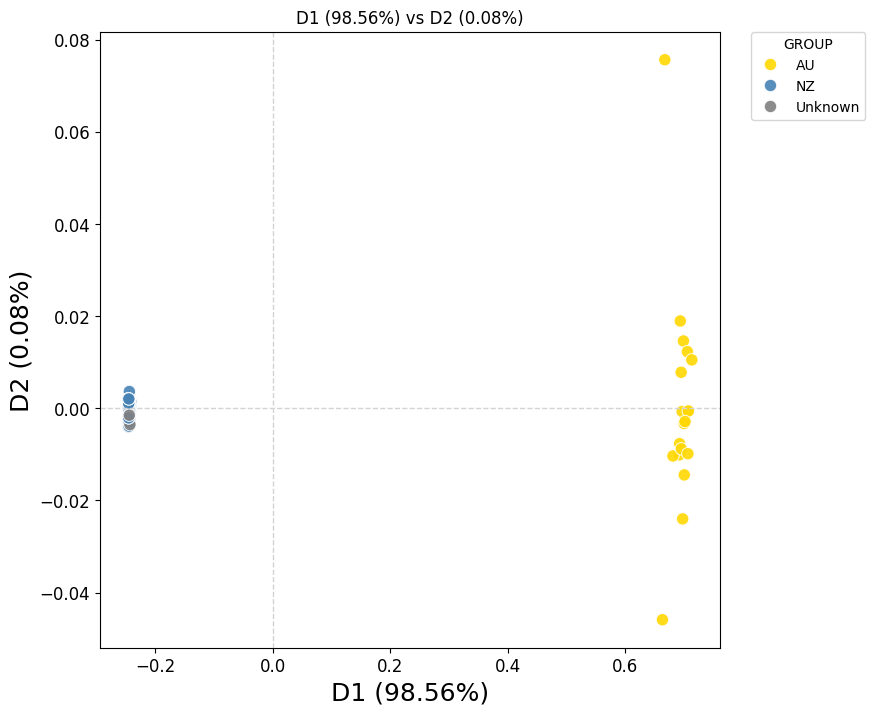

In [90]:
plot_mds(fairyNU, annot_input='angsd/neutral/structure/pop_list', 
    comp=(1,2), 
    s=80, 
    figsize=(8,8), 
    save='Git_Repos/2026_S_nereis_Cons_Gen/hold.png'
)

/tmp/ipykernel_8340/4255115675.py:62: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  mds["GROUP"].fillna("Unknown", inplace=True)


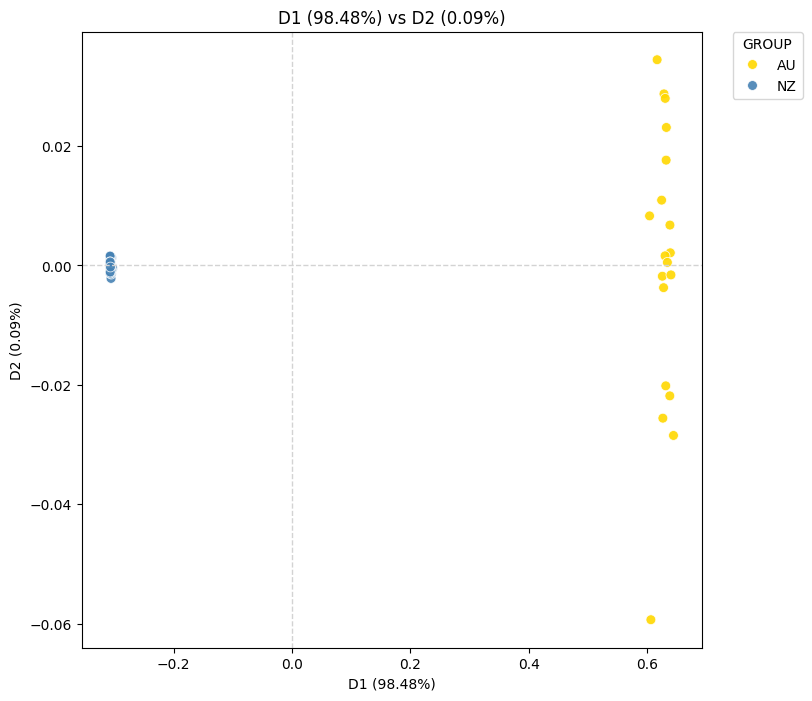

In [ ]:
plot_mds(fairyWG, annot_input='angsd/samtools/structure/pop_list', comp=(1,2), figsize=(8,8))

/tmp/ipykernel_19473/1857447244.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  mds["GROUP"].fillna("Unknown", inplace=True)
/tmp/ipykernel_19473/1857447244.py:80: UserWarning: 
The palette list has fewer values (10) than needed (13) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(


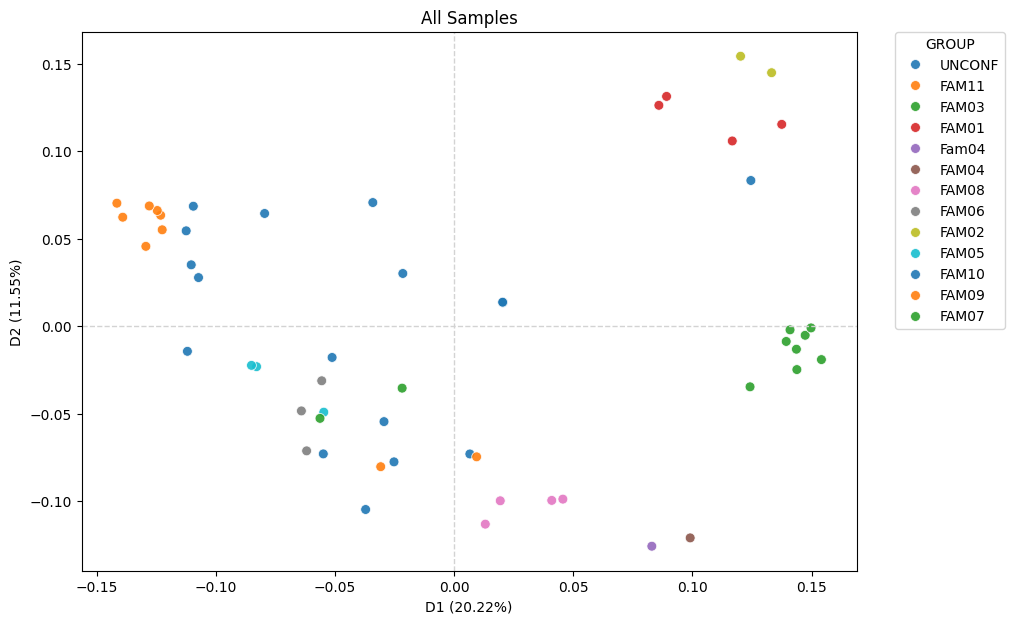

In [ ]:
plot_mds(total_result, annot_input='angsd/samtools/structure/ti_total_mds.list', comp=(1,2), figsize=(10,7), title='All Samples')

## Estimating Nucleotide Diversity (π)
We estimated nucleotide diversity (π) for the West Australian population of fairy tern and tara iti independently, using the site frequency spectrum (SFS) estimated above as a prior.  

In [ ]:

for POP in AU TI KI
    do
    if [[ "$POP" == "AU" ]]
        then
        angsd -P 26 -b ${ANGSD}${POP}.list -ref $REF -anc $ANC -sites $SITES -out ${ANGSD}${TOOL}diversity/${POP}_pest \
            -uniqueOnly 1 -remove_bads 1 -only_proper_pairs 1 -trim 0 -C 50 -baq 1 \
            -minMapQ 20 -minQ 20 -minInd 19 -setMinDepth 200 -setMaxDepth 420 -doCounts 1 \
            -GL 1 -doSaf 1 -pest ${ANGSD}${TOOL}/sfs/${POP}.sfs
        realSFS -p 40 -anc ${ANC} -ref ${REF} ${ANGSD}${TOOL}diversity/${POP}_pest.saf.idx > ${ANGSD}${TOOL}diversity/${POP}_pest.sfs
        realSFS saf2theta ${ANGSD}${TOOL}/diversity/${POP}_pest.saf.idx -sfs ${ANGSD}${TOOL}diversity/${POP}_pest.sfs -outname ${ANGSD}${TOOL}/diversity/${POP}_pest
        thetaStat do_stat ${ANGSD}${TOOL}/diversity/${POP}_pest.thetas.idx -win 10000 -step 1000 -outnames ${ANGSD}${TOOL}diversity/${POP}_pest_thetas_10KBwindows_1KBstep
        thetaStat do_stat ${ANGSD}${TOOL}/diversity/${POP}_pest.thetas.idx -win 50000 -step 10000 -outnames ${ANGSD}${TOOL}diversity/${POP}_pest_thetas_50KBwindows_10KBstep
        thetaStat do_stat ${ANGSD}${TOOL}/diversity/${POP}_pest.thetas.idx -outnames ${ANGSD}${TOOL}diversity/${POP}_pest_all_Thetas
    elif [[ "$POP" == "TI" ]]
        then
        angsd -P 26 -b ${ANGSD}${POP}.list -ref $REF -anc $ANC -sites $SITES -out ${ANGSD}${TOOL}diversity/${POP}_pest \
            -uniqueOnly 1 -remove_bads 1 -only_proper_pairs 1 -trim 0 -C 50 -baq 1 \
            -minMapQ 20 -minQ 20 -minInd 15 -setMinDepth 120 -setMaxDepth 280 -doCounts 1 \
            -GL 1 -doSaf 1 -pest ${ANGSD}${TOOL}/sfs/${POP}.sfs
        realSFS -p 40 -anc ${ANC} -ref ${REF} ${ANGSD}${TOOL}diversity/${POP}_pest.saf.idx > ${ANGSD}${TOOL}diversity/${POP}_pest.sfs
        realSFS saf2theta ${ANGSD}${TOOL}/diversity/${POP}_pest.saf.idx -sfs ${ANGSD}${TOOL}diversity/${POP}_pest.sfs -outname ${ANGSD}${TOOL}/diversity/${POP}_pest
        thetaStat do_stat ${ANGSD}${TOOL}/diversity/${POP}_pest.thetas.idx -win 10000 -step 1000 -outnames ${ANGSD}${TOOL}diversity/${POP}_pest_thetas_10KBwindows_1KBstep
        thetaStat do_stat ${ANGSD}${TOOL}/diversity/${POP}_pest.thetas.idx -win 50000 -step 10000 -outnames ${ANGSD}${TOOL}diversity/${POP}_pest_thetas_50KBwindows_10KBstep
        thetaStat do_stat ${ANGSD}${TOOL}/diversity/${POP}_pest.thetas.idx -outnames ${ANGSD}${TOOL}diversity/${POP}_pest_all_Thetas
    else
        angsd -P 26 -b ${ANGSD}${POP}.list -ref $REF -anc $ANC -sites $SITES -out ${ANGSD}${TOOL}diversity/${POP}_pest \
            -uniqueOnly 1 -remove_bads 1 -only_proper_pairs 1 -trim 0 -C 50 -baq 1 \
            -minMapQ 20 -minQ 20 -minInd 24 -setMinDepth 700 -setMaxDepth 1200 -doCounts 1 \
            -GL 1 -doSaf 1 -pest ${ANGSD}${TOOL}/sfs/${POP}.sfs
        realSFS -p 40 -anc ${ANC} -ref ${REF} ${ANGSD}${TOOL}diversity/${POP}_pest.saf.idx > ${ANGSD}${TOOL}diversity/${POP}_pest.sfs
        realSFS saf2theta ${ANGSD}${TOOL}/diversity/${POP}_pest.saf.idx -sfs ${ANGSD}${TOOL}diversity/${POP}_pest.sfs -outname ${ANGSD}${TOOL}/diversity/${POP}_pest
        thetaStat do_stat ${ANGSD}${TOOL}/diversity/${POP}_pest.thetas.idx -win 10000 -step 1000 -outnames ${ANGSD}${TOOL}diversity/${POP}_pest_thetas_10KBwindows_1KBstep
        thetaStat do_stat ${ANGSD}${TOOL}/diversity/${POP}_pest.thetas.idx -win 50000 -step 10000 -outnames ${ANGSD}${TOOL}diversity/${POP}_pest_thetas_50KBwindows_10KBstep
        thetaStat do_stat ${ANGSD}${TOOL}/diversity/${POP}_pest.thetas.idx -outnames ${ANGSD}${TOOL}diversity/${POP}_pest_all_Thetas
done

plotting nucleotide diversity

In [3]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.legend_handler import HandlerTuple
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

path = '/nesi/nobackup/uc03718/'
os.chdir(path)
print(os.getcwd())

/nesi/nobackup/uc03718


In [39]:
cols=["Chr", "WinCenter", "tW", "tP", "tF", "tH", "tL", "Tajima", "fuf", "fud", "fayh", "zeng", "nSites"]
desired_order = ['scaffold_1', 'scaffold_2', 'scaffold_3', 'scaffold_5',
                 'scaffold_6', 'scaffold_7', 'scaffold_8', 'scaffold_9',
                 'scaffold_10', 'scaffold_11', 'scaffold_12', 'scaffold_13',
                 'scaffold_14', 'scaffold_15', 'scaffold_16', 'scaffold_17',
                 'scaffold_18', 'scaffold_19', 'scaffold_20', 'scaffold_21',
                 'scaffold_22', 'scaffold_23', 'scaffold_24', 'scaffold_25',
                 'scaffold_26', 'scaffold_27', 'scaffold_28'
                 ]

#au_neutralPi = pd.read_csv('angsd/neutral/diversity/AU_neutral_thetas_50KBwindows_10KBstep.pestPG', sep='\t', usecols=cols)
ti_neutralPi = pd.read_csv('angsd/neutral/diversity/TI_neutral_thetas_50KBwindows_10KBstep.pestPG', sep='\t', usecols=cols)
#ki_neutralPi = pd.read_csv('angsd/neutral/diversity/KI_neutral_thetas_50KBwindows_10KBstep.pestPG', sep='\t', usecols=cols)

au_wholeGenomePi = pd.read_csv('angsd/samtools/diversity/AU_whole-genome_thetas_50KBwindows_10KBstep.pestPG', sep='\t', usecols=cols)
ti_wholeGenomePi = pd.read_csv('angsd/samtools/diversity/TI_whole-genome_thetas_50KBwindows_10KBstep.pestPG', sep='\t', usecols=cols)
ki_wholeGenomePi = pd.read_csv('angsd/samtools/diversity/KI_whole-genome_thetas_50KBwindows_10KBstep.pestPG', sep='\t', usecols=cols)

#ki_neutralPi['Chr'] = pd.Categorical(ki_neutralpi['Chr'], categories=desired_order, ordered=True)
#ki_neutralPi = ki_neutralpi.sort_values(['Chr', 'WinCenter'])

ki_wholeGenomePi['Chr'] = pd.Categorical(ki_wholeGenomePi['Chr'], categories=desired_order, ordered=True)
ki_wholeGenomePi = ki_wholeGenomePi.sort_values(['Chr', 'WinCenter'])

#au_neutralPi['Nucleotide Diversity'] = (au_neutralPi['tP'] / au_neutralPi['nSites'])
ti_neutralPi['Nucleotide Diversity'] = (ti_neutralPi["tP"] / ti_neutralPi["nSites"])
#ki_neutralPi['Nucleotide Diversity'] = (ki_neutralPi["tP"] / ki_neutralPi["nSites"])
au_wholeGenomePi['Nucleotide Diversity'] = (au_wholeGenomePi['tP'] / au_wholeGenomePi['nSites'])
ti_wholeGenomePi['Nucleotide Diversity'] = (ti_wholeGenomePi["tP"] / ti_wholeGenomePi["nSites"])
ki_wholeGenomePi['Nucleotide Diversity'] = (ki_wholeGenomePi["tP"] / ki_wholeGenomePi["nSites"])

#au_neutralPi['x'] = range(len(au_neutralPi))
ti_neutralPi['x'] = range(len(ti_neutralPi))
#ki_neutralPi['x'] = range(len(ki_neutralPi))
au_wholeGenomePi['x'] = range(len(au_wholeGenomePi))
ti_wholeGenomePi['x'] = range(len(ti_wholeGenomePi))
ki_wholeGenomePi['x'] = range(len(ki_wholeGenomePi))

/tmp/ipykernel_8340/3546549695.py:14: UserWarning: 
The palette list has fewer values (2) than needed (25) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data=ti_neutralPi, x='x', y='Nucleotide Diversity', hue='Chr', palette=nzpalette, alpha=0.5, s=3, legend=False, edgecolor='none', ax=axs[1])


[]

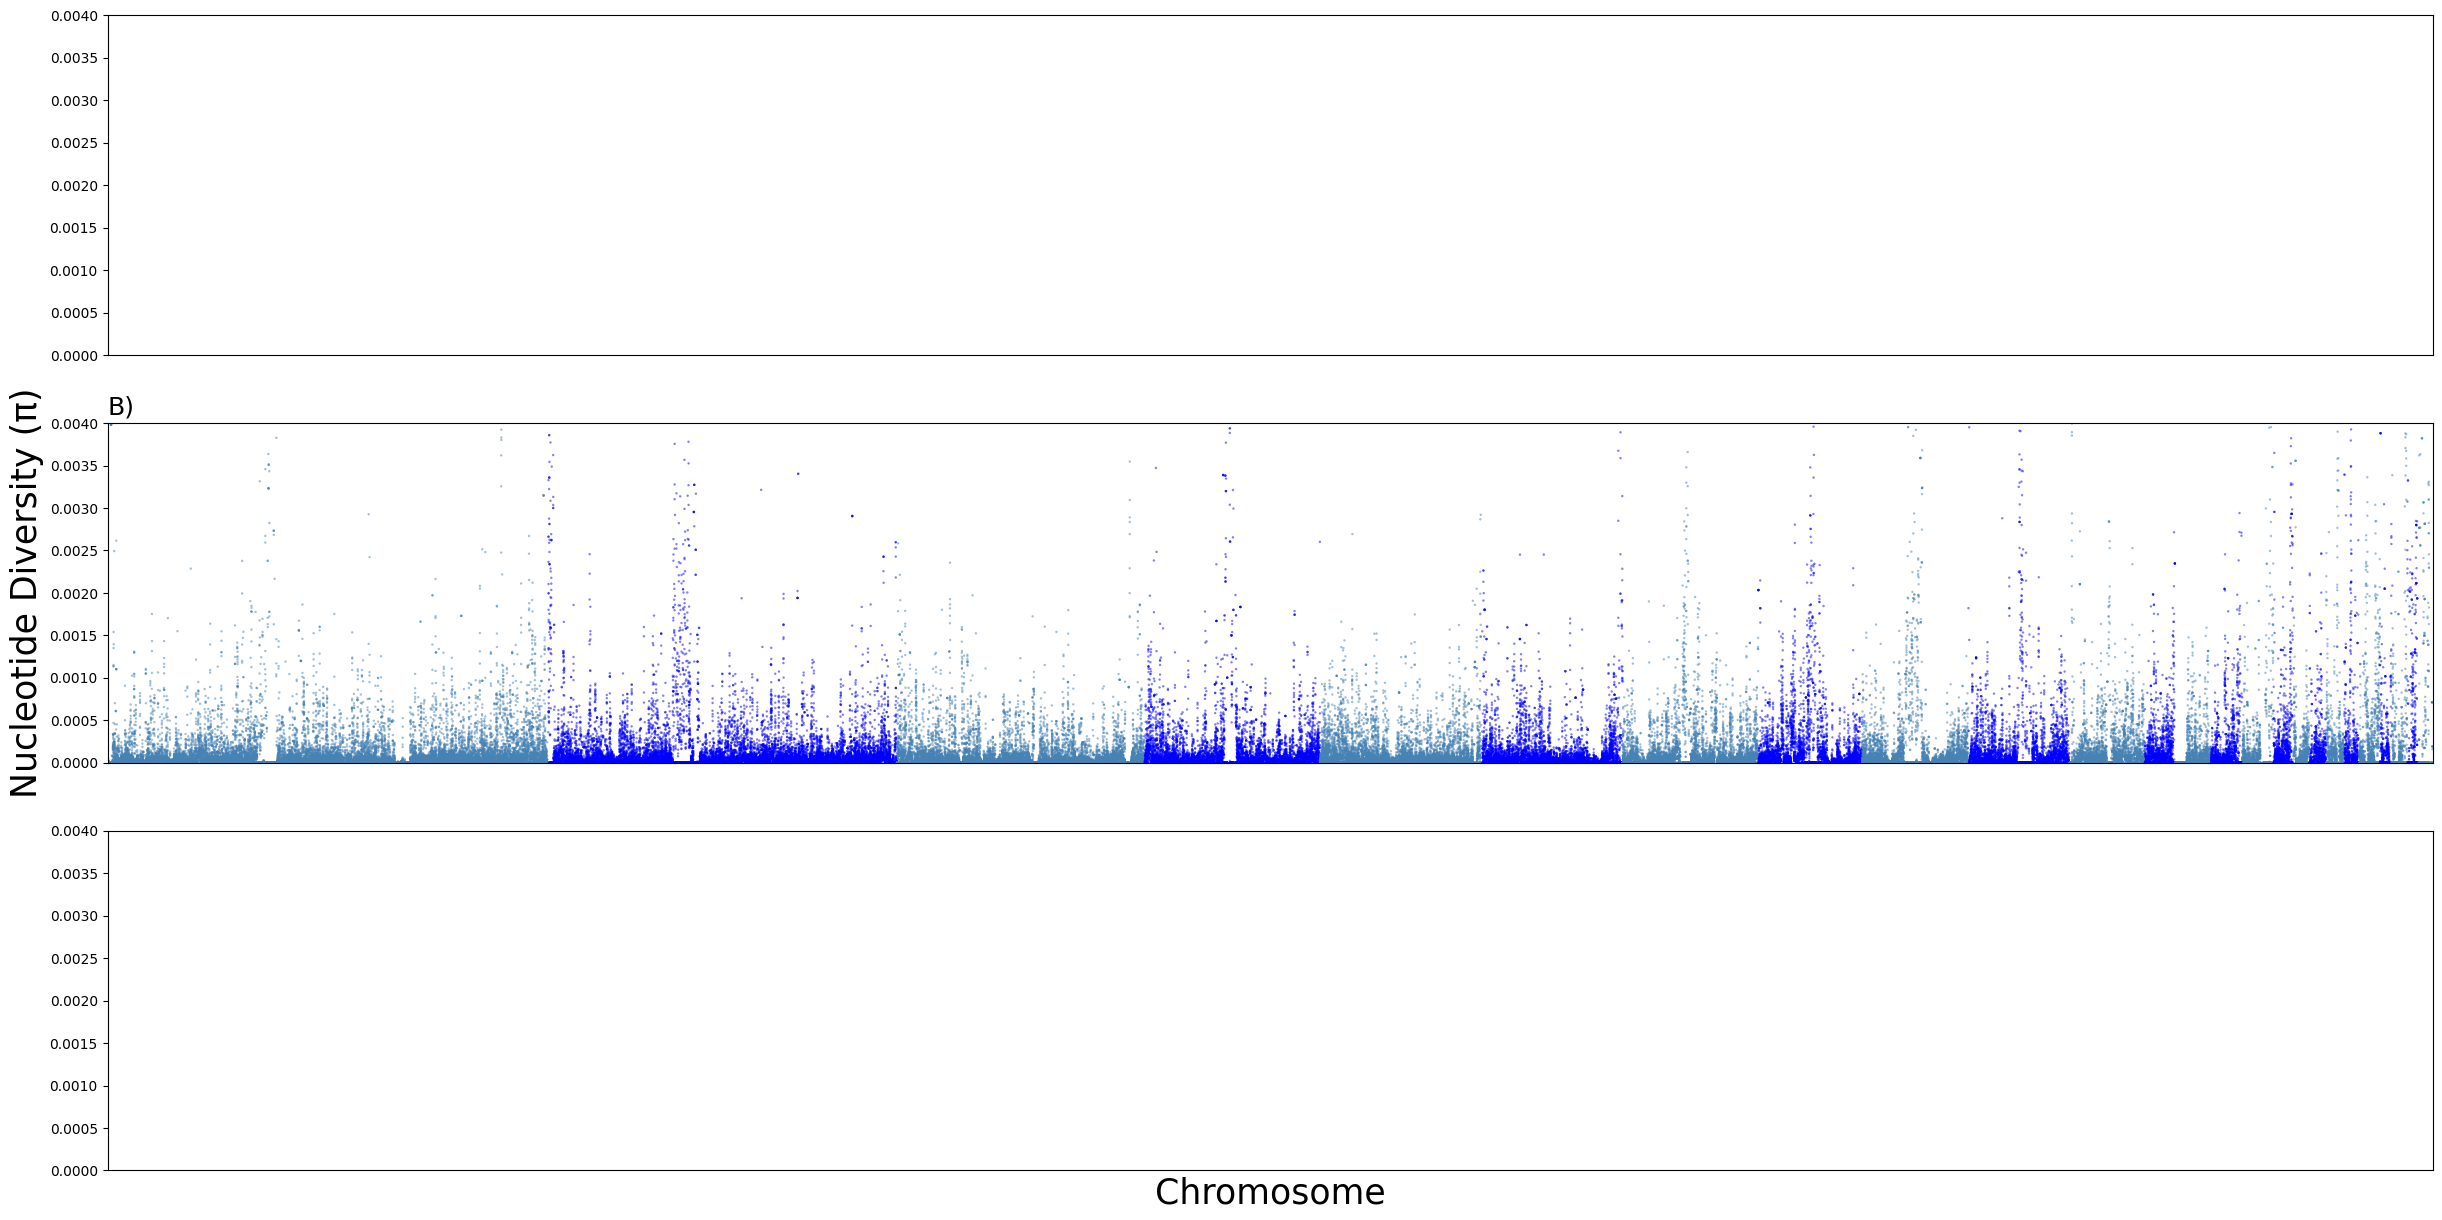

In [ ]:
aupalette = ['gold', 'orange']
nzpalette = ['steelblue', 'blue']
kipalette = ['grey', 'black']

fig, axs = plt.subplots(3, 1, figsize=(30, 15), sharex=True, sharey=True)

#sns.scatterplot(data=au_neutralPi, x='x', y='Nucleotide Diversity', hue='Chr', palette=aupalette, alpha=0.5, s=3, legend=False, edgecolor='none', ax=axs[0])
#axs[0].set_title('A)', fontsize=18, loc='left')
#axs[0].set_xlim(0, len(au_neutralPi))
#axs[0].set_xlabel(xlabel=None)
#axs[0].set_ylabel('')
#axs[0].set_ylim(0, 0.03)

sns.scatterplot(data=ti_neutralPi, x='x', y='Nucleotide Diversity', hue='Chr', palette=nzpalette, alpha=0.5, s=3, legend=False, edgecolor='none', ax=axs[1])
axs[1].set_title('B)', fontsize=18, loc='left')
axs[1].set_xlim(0, len(ti_neutralPi))
axs[1].set_xlabel('')
axs[1].set_ylabel('Nucleotide Diversity (π)', fontsize=25)
axs[1].set_ylim(0, 0.004)

#sns.scatterplot(data=ki_neutralPi, x='x', y='Nucleotide Diversity', hue='Chr', palette=kipalette, alpha=0.5, s=3, legend=False, edgecolor='none', ax=axs[2])
#axs[2].set_xlim(0, len(ki_neutralPi))
#axs[2].set_ylabel('')
#axs[2].set_ylim(0, 0.004)
#axs[2].set_title('D)', fontsize=18, loc='left')

axs[-1].set_xlabel('Chromosome', fontsize=25)
axs[-1].set_xticks([])

#plt.savefig('Git_Repos/2026_S_nereis_Cons_Gen/Figures/nucleotideDiversity_neutral_closeY.png', dpi=300, bbox_inches='tight')

/tmp/ipykernel_8340/2996538874.py:8: UserWarning: 
The palette list has fewer values (2) than needed (25) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data=au_wholeGenomePi, x='x', y='Nucleotide Diversity', hue='Chr', palette=aupalette, alpha=0.5, s=3, legend=False, edgecolor='none', ax=axs[0])


/tmp/ipykernel_8340/2996538874.py:15: UserWarning: 
The palette list has fewer values (2) than needed (25) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data=ti_wholeGenomePi, x='x', y='Nucleotide Diversity', hue='Chr', palette=nzpalette, alpha=0.5, s=3, legend=False, edgecolor='none', ax=axs[1])
/tmp/ipykernel_8340/2996538874.py:22: UserWarning: 
The palette list has fewer values (2) than needed (27) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data=ki_wholeGenomePi, x='x', y='Nucleotide Diversity', hue='Chr', palette=kipalette, alpha=0.5, s=3, legend=False, edgecolor='none', ax=axs[2])


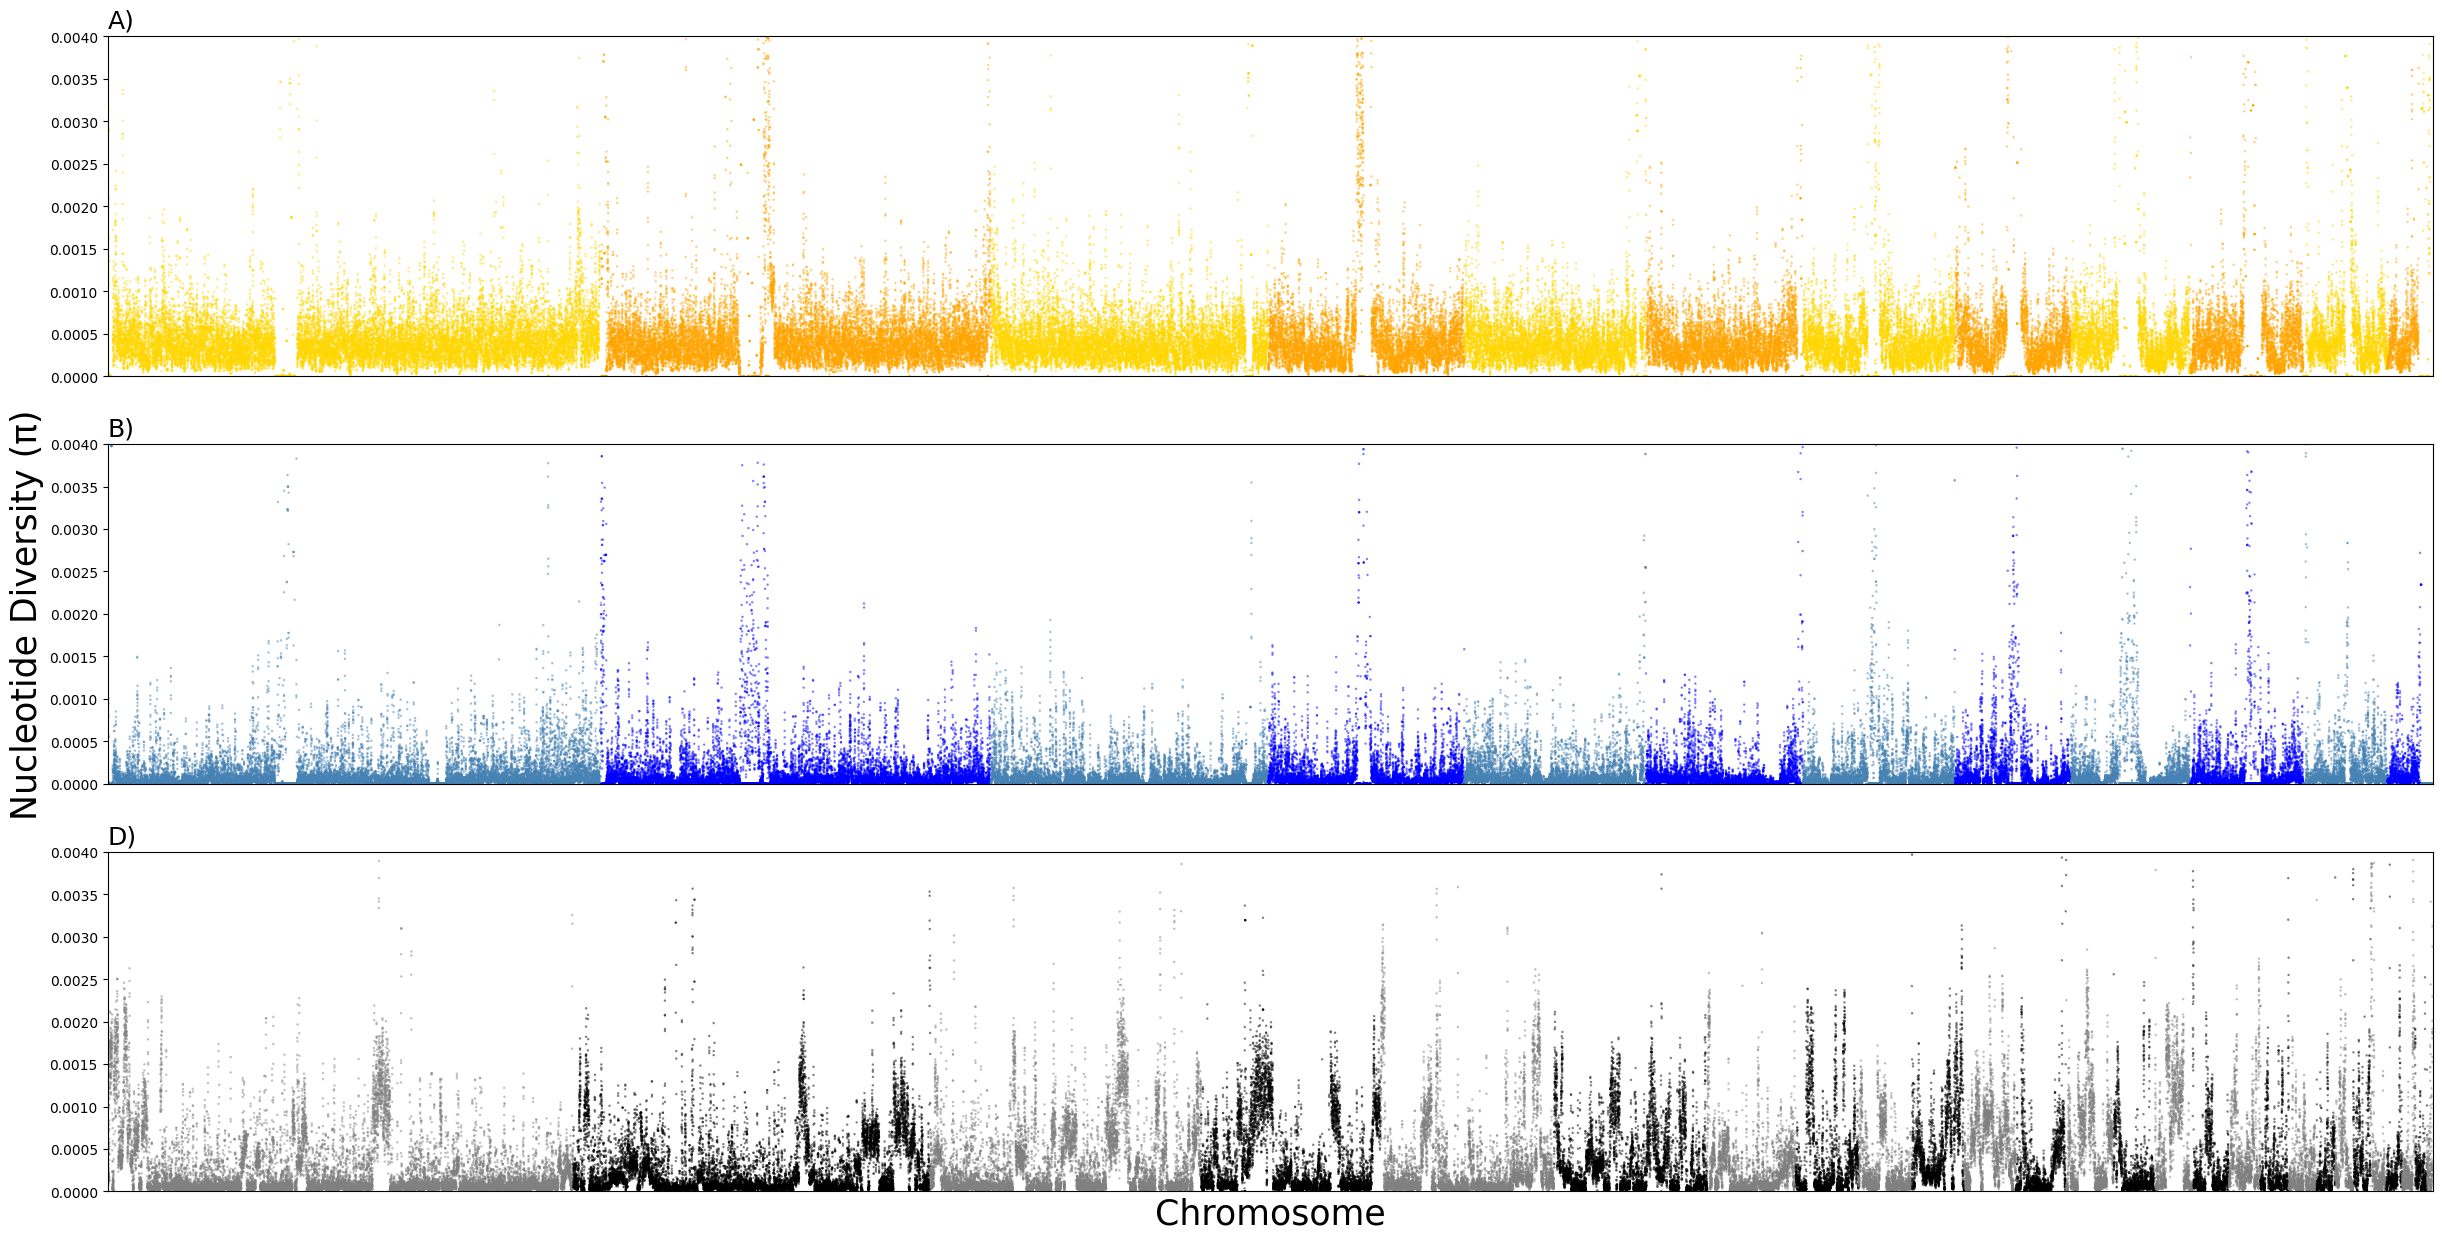

In [47]:
aupalette = ['gold', 'orange']
nzpalette = ['steelblue', 'blue']
kipalette = ['grey', 'black']


fig, axs = plt.subplots(3, 1, figsize=(30, 15), sharex=True, sharey=True)

sns.scatterplot(data=au_wholeGenomePi, x='x', y='Nucleotide Diversity', hue='Chr', palette=aupalette, alpha=0.5, s=3, legend=False, edgecolor='none', ax=axs[0])
axs[0].set_title('A)', fontsize=18, loc='left')
axs[0].set_xlim(0, len(au_wholeGenomePi))
axs[0].set_xlabel(xlabel=None)
axs[0].set_ylabel('')
axs[0].set_ylim(0, 0.03)

sns.scatterplot(data=ti_wholeGenomePi, x='x', y='Nucleotide Diversity', hue='Chr', palette=nzpalette, alpha=0.5, s=3, legend=False, edgecolor='none', ax=axs[1])
axs[1].set_title('B)', fontsize=18, loc='left')
axs[1].set_xlim(0, len(ti_wholeGenomePi))
axs[1].set_xlabel('')
axs[1].set_ylabel('Nucleotide Diversity (π)', fontsize=25)
axs[1].set_ylim(0, 0.004)

sns.scatterplot(data=ki_wholeGenomePi, x='x', y='Nucleotide Diversity', hue='Chr', palette=kipalette, alpha=0.5, s=3, legend=False, edgecolor='none', ax=axs[2])
axs[2].set_xlim(0, len(ki_wholeGenomePi))
axs[2].set_ylabel('')
axs[2].set_ylim(0, 0.004)
axs[2].set_title('D)', fontsize=18, loc='left')

axs[-1].set_xlabel('Chromosome', fontsize=25)
axs[-1].set_xticks([])

plt.savefig('Git_Repos/2026_S_nereis_Cons_Gen/Figures/nucleotideDiversity_whole-genome_closeY.png', dpi=300, bbox_inches='tight')

## Estimating D<sub>XY</sub>
When aiming to estimate D<sub>XY</sub>, we need to first get a list of sites variable in each population. This is so sites that may be fixed in one population are included in our estimates.  

In [ ]:
angsd -P 24 -b ${ANGSD}AU.list -ref $TREF -anc $TANC -sites $TSITES -out ${ANGSD}neutral/diversity/AU_initialDxy \
    -uniqueOnly 1 -remove_bads 1 -only_proper_pairs 1 -trim 0 -C 50 -baq 1 -minMapQ 20 -minQ 20 \
    -minInd 19 -setMinDepth 200 -setMaxDepth 420 -doCounts 1 -doMajorMinor 1 \
    -GL 1 -doMaf 1 -skipTriallelic 1 -SNP_pval 1e-6

angsd -P 24 -b ${ANGSD}TI.list -ref $TREF -anc $TANC -sites $TSITES -out ${ANGSD}neutral/diversity/TI_initialDxy \
    -uniqueOnly 1 -remove_bads 1 -only_proper_pairs 1 -trim 0 -C 50 -baq 1 -minMapQ 20 -minQ 20 \
    -minInd 15 -setMinDepth 120 -setMaxDepth 280 -doCounts 1 -doMajorMinor 1 \
    -GL 1 -doMaf 1 -skipTriallelic 1 -SNP_pval 1e-6

angsd -P 24 -b ${ANGSD}AU.list -ref $TREF -anc $TANC -out ${ANGSD}samtools/diversity/AU_initialDxy \
    -uniqueOnly 1 -remove_bads 1 -only_proper_pairs 1 -trim 0 -C 50 -baq 1 -minMapQ 20 -minQ 20 \
    -minInd 19 -setMinDepth 200 -setMaxDepth 420 -doCounts 1 -doMajorMinor 1 \
    -GL 1 -doMaf 1 -skipTriallelic 1 -SNP_pval 1e-6

angsd -P 24 -b ${ANGSD}TI.list -ref $TREF -anc $TANC -out ${ANGSD}samtools/diversity/TI_initialDxy \
    -uniqueOnly 1 -remove_bads 1 -only_proper_pairs 1 -trim 0 -C 50 -baq 1 -minMapQ 20 -minQ 20 \
    -minInd 15 -setMinDepth 120 -setMaxDepth 280 -doCounts 1 -doMajorMinor 1 \
    -GL 1 -doMaf 1 -skipTriallelic 1 -SNP_pval 1e-6

We then extracted the chromosome and position from each population and merge them into a sites file.  

In [ ]:
zcat ${ANGSD}neutral/diversity/{AU,TI}_initialDxy.mafs.gz | awk '{print $1"\t"$2}' | grep -v "chromo" | sort -k1,1 -k2,2n | uniq > ${ANGSD}neutral_Dxy_sites.bed
zcat ${ANGSD}samtools/diversity/*_initialDxy.mafs.gz | awk '{print $1"\t"$2}' | grep -v "chromo" | sort -k1,1 -k2,2n | uniq > ${ANGSD}whole-genome_Dxy_sites.bed

angsd sites index neutral_Dxy_sites.bed
angsd sites index whole-genome_Dxy_sites.bed

And finally estimated allele frequency estimates at these overlapping sites.  

In [ ]:
for POP in AU TI
    do
    angsd -P 26 -b ${ANGSD}${POP}.list -ref $REF -anc $ANC -sites ${ANGSD}neutral_DXYsites.bed \
        -out ${ANGSD}neutral/diversity/${POP}_anc_DXY -GL 1 -doMajorMinor 5 -doMaf 1
    angsd -P 26 -b ${ANGSD}${POP}.list -ref $REF -sites ${ANGSD}neutral_DXYsites.bed \
        -out ${ANGSD}neutral/diversity/${POP}_ref_DXY -GL 1 -doMajorMinor 4 -doMaf 1
    angsd -P 26 -b ${ANGSD}${POP}.list -ref $REF -anc $ANC -sites ${ANGSD}whole-genome_DXYsites.bed \
        -out ${ANGSD}samtools/diversity/${POP}_anc_DXY -GL 1 -doMajorMinor 5 -doMaf 1
    angsd -P 26 -b ${ANGSD}${POP}.list -ref $REF -sites ${ANGSD}whole-genome_DXYsites.bed \
        -out ${ANGSD}samtools/diversity/${POP}_ref_DXY -GL 1 -doMajorMinor 4 -doMaf 1
done

And finally we adapted a Rscript by Joshua Penalba [here](https://github.com/mfumagalli/ngsPopGen/blob/master/scripts/calcDxy.R) to calculate DXY using the allele frequencies in each respective population's MAF file.

## Tajima's D
Here, we plot Tajima's D estimates for Australian fairy tern and tara iti.  

/tmp/ipykernel_8340/981549597.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tiTajima['x'] = range(len(tiTajima))
/tmp/ipykernel_8340/981549597.py:9: UserWarning: 
The palette list has fewer values (2) than needed (25) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data=tiTajima, x='x', y='Tajima', hue='Chr', palette=nzpalette, alpha=0.5, s=3, legend=False, ax=axs[1])


AttributeError: 'numpy.ndarray' object has no attribute 'set_ylabel'

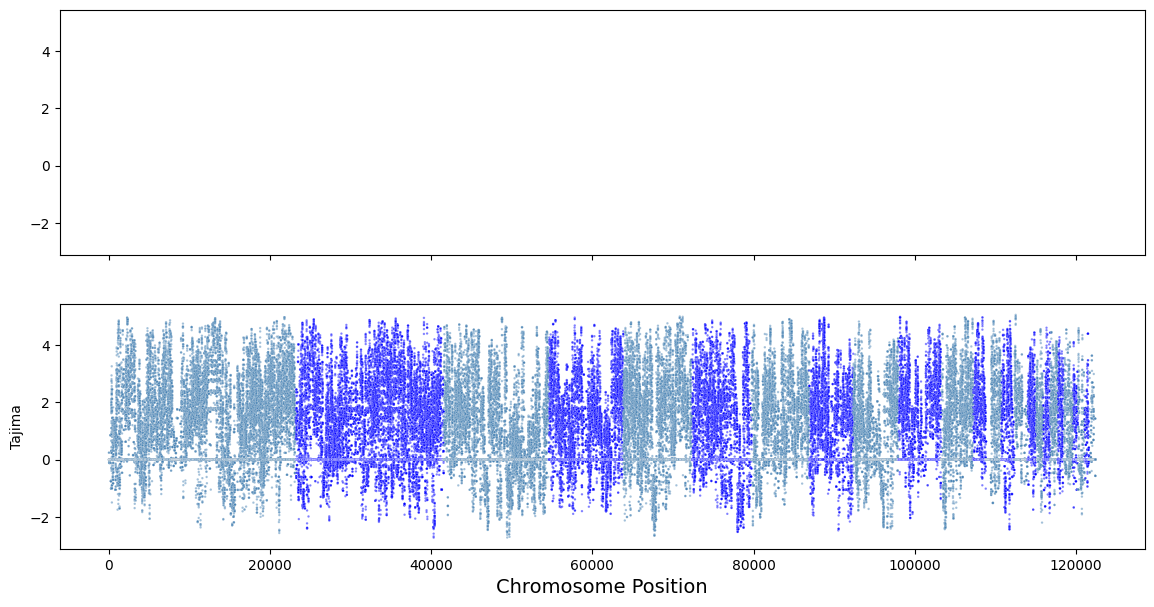

In [45]:
#auTajima = au_neutralPi[['Chr', 'WinCenter', 'Tajima', 'nSites']]
tiTajima = ti_neutralPi[['Chr', 'WinCenter', 'Tajima', 'nSites']]

#auTajima['x'] = range(len(auTajima))
tiTajima['x'] = range(len(tiTajima))

fig, axs = plt.subplots(2, 1, figsize=(14, 7), sharex=True, sharey=True)
#sns.scatterplot(data=auTajima, x='x', y='Tajima', hue='Chr', palette=aupalette, alpha=0.5, s=3, legend=False, ax=axs[0])
sns.scatterplot(data=tiTajima, x='x', y='Tajima', hue='Chr', palette=nzpalette, alpha=0.5, s=3, legend=False, ax=axs[1])

axs[-1].set_xlabel('Chromosome Position', fontsize=14)
axs.set_ylabel("Tajima's D", fontsize=14)

#plt.savefig('plots/GLOBAL_Tajima_neutralSites.png')